OLD NOTEBOOK: SEE osm_pbf_power_data_extractor.py which does everything.

In [1]:
import os, sys, time

import requests
import shutil

# https://gitlab.com/dlr-ve-esy/esy-osmfilter/-/tree/master/
from esy.osmfilter import osm_colors as CC
from esy.osmfilter import run_filter, Node, Way, Relation
from esy.osmfilter import export_geojson
from contextlib import contextmanager

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import geoplot
import matplotlib.pyplot as plt

# import logging
# logging.basicConfig()
# logger=logging.getLogger(__name__)
# logger.setLevel(logging.INFO)
# logger.setLevel(logging.WARNING)

In [2]:
geofabrik_regions = [
    "africa"
]  # ["algeria","angola","benin","botswana","burkina_faso","burundi","cameroon","canary_islands","cape_verde","central_african_republic","chad","comores","congo_brazzaville","congo_democratic_republic","djibouti","egypt","equatorial_guinea","eritrea","ethiopia","gabon","ghana","guinea_bissau","guinea","ivory_coast","kenya","lesotho","liberia","libya","madagascar","malawi","mali","mauritania","mauritius","morocco","mozambique","namibia","niger","nigeria","rwanda","saint_helena_ascension_and_tristan_da_cunha","sao_tome_and_principe","senegal_and_gambia","seychelles","sierra_leone","somalia","south_africa_and_lesotho","south_africa","south_sudan","sudan","swaziland","tanzania","togo","tunisia","uganda","zambia","zimbabwe"]

In [16]:
country_name = "africa"  #'egypt' #'africa' TODO: Create dictionary with country_code : country_name pairs
country_code = "AFRICA"  #'egypt' #'AFRICA'
update = True  # prevents re-download and filteration of file
element_file_exists = False

# json file for the Data dictionary
# json file for the Elements dictionary is automatically written to 'data/osm/Elements'+filename)
JSON_outputfile = os.path.join(os.getcwd(), "data", "osm", country_name + "_lines.json")

if os.path.exists(JSON_outputfile):
    element_file_exists = True

geofabrik_filename = f"{country_name}-latest.osm.pbf"  # Filename for geofabrik
if geofabrik_regions == ["africa"]:
    geofabrik_url = f"https://download.geofabrik.de/africa/africa-latest.osm.pbf"
else:
    geofabrik_url = f"https://download.geofabrik.de/africa/africa-latest.osm.pbf"
    # geofabrik_url = f'https://download.geofabrik.de/africa/{geofabrik_filename}' # https://download.geofabrik.de/africa/nigeria-latest.osm.pbf

PBF_inputfile = os.path.join(
    os.getcwd(), "data", "osm", "pbf", geofabrik_filename
)  # Input filepath

if not os.path.exists(PBF_inputfile) or update or element_file_exists is False:
    print(f"{geofabrik_filename} does not exist, downloading to {PBF_inputfile}")
    os.makedirs(
        os.path.dirname(PBF_inputfile), exist_ok=True
    )  # create data/osm directory
    with requests.get(geofabrik_url, stream=True) as r:
        with open(PBF_inputfile, "wb") as f:
            shutil.copyfileobj(r.raw, f)

africa-latest.osm.pbf does not exist, downloading to /home/max/OneDrive/PHD-Flexibility/07_pypsa-africa/0github/pypsa-africa/data_exploration/data/osm/pbf/africa-latest.osm.pbf


In [17]:
print(PBF_inputfile, JSON_outputfile)

/home/max/OneDrive/PHD-Flexibility/07_pypsa-africa/0github/pypsa-africa/data_exploration/data/osm/pbf/africa-latest.osm.pbf /home/max/OneDrive/PHD-Flexibility/07_pypsa-africa/0github/pypsa-africa/data_exploration/data/osm/africa_lines.json


In [18]:
# see https://dlr-ve-esy.gitlab.io/esy-osmfilter/filter.html for filter structures

prefilter = {
    Node: {"power": ["line"]},
    Way: {"power": ["line"]},
    Relation: {"power": ["line"]},
}
blackfilter = [
    ("pipeline", "line"),
]  # HACKY: due to esy.osmfilter
whitefilter = [
    [
        ("power", "line"),
    ],
]

elementname = f"{country_code}_line"

if update is False and element_file_exists is True:
    create_elements = False  # Do not create elements again
    new_prefilter_data = False  # Do not pre-filter data again
    print("Loading Pickle")
else:
    create_elements = True  # Do not create elements again
    new_prefilter_data = True  # Do not pre-filter data again
    print("Creating  New Elements")

[Data, Elements] = run_filter(
    elementname,
    PBF_inputfile,
    JSON_outputfile,
    prefilter,
    whitefilter,
    blackfilter,
    NewPreFilterData=new_prefilter_data,
    CreateElements=create_elements,
    LoadElements=True,
    verbose=False,
    multiprocess=True,
)


# export the elements to a geojson-file
# export_geojson(Elements[elementname]['Way'],Data,filename='test.geojson',jsontype='Line')
# convert extract node elements
# export_geojson(Elements[elementname]['Node'],Data,filename='test.geojson',jsontype='Point')

Creating  New Elements


DecodeError: Error parsing message

In [362]:
# display(Data['Node'])
# display(Data['Way'])
# display(Elements[elementname])


# From https://dlr-ve-esy.gitlab.io/esy-osmfilter/usage.html
# >>> len(Data['Node'])
# 13
# >>> len(Data['Relation'])
# 0
# >>> len(Data['Way'])

In [363]:
pd.set_option("display.max_colwidth", None)

df_way = pd.json_normalize(Elements[elementname]["Way"].values())
df_way.dropna(
    subset=["tags.voltage"], inplace=True
)  # Drop any substations with Voltage = N/A
# na_values_voltage = df_way.isna().sum()
df_way.dropna(
    thresh=len(df_way) * 0.25, axis=1, how="all", inplace=True
)  # Drop Columns with 75% values as N/A
display(df_way)


###Check data
##Check unique input in column 6, tag.source
# pd.unique(df_way.iloc[:,6])
##Check unique input in column 4, tag.voltage
# pd.unique(df_way.iloc[:,4])
##Check unique input in column 7, tag.wires
# pd.unique(df_way.iloc[:,7])
# df_way.refs

,id,refs,tags.power,tags.cables,tags.voltage,tags.source
0,102977104,"[315125784, 1189180705, 1894549491]",line,3,220000,NaN
2,219020310,"[2282351555, 2282351554, 2282351560, 2282351572, 2282351565, 2282351549, 2282351546, 2282351544, 2282351543, 2282351541, 2282351538, 2282351536, 2282351534, 2282351530, 2282351529, 2282351527, 2282351525, 2282351523, 2282351520, 2282351518, 2282351516, 2282351515, 2282351513, 2282351511, 2282351508, 2282351507, 2282351505, 2282351503, 2282351501, 2282351498, 2282351496, 2282351494, 2282351492, 2282351491, 2282351489, 2282351486, 2282351484, 2282351482, 2282351480, 2282351477, 2282351471, 2282351469, 2282351466, 2282351456, 2282351440, 2282351429, 2282351425, 2282351420, 2282351416, 2282351411, 2282351410, 2282351409, 2282351406, 2282351403, 2282351401, 2282351398, 2282351396, 2282351394, 2282351392, 2282351390, 2282351387, 2282351383, 2282351381, 2282351379, 2282351376, 2282351374, 2282351371, 2282351369, 2282351365, 2282351363, 2282351360, 2282351358, 2282351355, 2282351353, 2282351356, 2282351357, 2282351359, 2282351362, 2282351364, 2282351366, 2282351368, 2282351370, 2282351373, 2282351375, 7488846421, 2282351377, 2282351380, 2282351382, 2282351389, 2282351400, 2282351408, 2282351414, 7488846419, 2282351418, 2282351423, 2282351427, 2282351433, 2282351447, 2282351445, 2282351444, ...]",line,6,220000,bing
3,448830775,"[4458067859, 4458067867, 4458067868]",line,3,132000,NaN
4,448963663,"[4459313101, 4459313105, 1153332694]",line,3,220000,NaN
5,448685912,"[4456722152, 4456722154, 1895268379]",line,3,66000,NaN
...,...,...,...,...,...,...
1884,113013939,"[4262436118, 4262436115, 4262436111, 4262436109, 4262436107, 4262436114, 4262436122, 4262436125, 4262436128, 4262436130, 4262436132, 4262436134, 4262436136, 4262436137, 4262436139, 4262436141, 4262436143, 4262436145, 4262436147, 4262436149, 4262436409, 4262436411, 4262436413, 4262436415, 4262436417, 4262436419, 4262436420, 4262436422, 4262436424, 4262436426, 4262436428, 4262436430, 4262436431, 4262436433, 4262436435, 4262436437, 4262436439, 4262436441, 4262436443, 1282966627, 1282966531, 1282966652, 1282966603, 1282966788, 1282966619, 1282966484, 1282966812, 1282966639, 1282966805, 1282966656, 1282966513, 1282966573, 1282966715, 1282966796, 1282966588, 1282966772, 1282966791, 1282966524, 1282966696, 1282966556, 1282966510, 1282966756, 1282966527, 1283060188, 1283060164, 1283060201, 1283060161, 1283060168, 1283060192, 1283060194, 1283060158, 1283060187, 4262216257, 4262216258, 4262216259, 4262216260, 4262216261, 4262216262, 4262216263, 4262216269, 4262216270, 4262216271, 4262216272, 4262216273, 4262216274, 4262216275, 4262216276, 4262216277, 4262216278, 4262216279, 4262216280, 4262216281, 4262216282, 4262216283, 4262216284, 4262216285, 4262216286, 4262216287, 4262216288, 4262219789, ...]",line,6,66000,NaN
1885,276514646,"[1871965858, 1871965856, 2811109213, 2811109212]",line,3,220000,Bing
1887,694560059,"[7006779708, 7006779709, 7006779710, 6521852521, 6521852522, 6521852523, 6521852524, 6521852525, 6521852526, 6521852527, 6521852528, 6521852529, 6521852530, 6521852531, 6521852532, 6521852533, 6521852534, 6521852520, 6521852519, 6521852518, 6521852517, 6521852516]",line,6,500000,NaN
1888,102984752,"[1434117329, 727583334, 727582845, 727581598, 727579786]",line,6,220000,NaN


In [364]:
# pd.json_normalize(Data["Node"].values())

In [365]:
df_node = pd.json_normalize(Data["Node"].values())
df_node.dropna(
    thresh=len(df_node) * 0.25, axis=1, how="all", inplace=True
)  # Drop Columns with 75% values as N/A
# display(df_node)

[(31.551713800000005, 30.08993810000004), (32.92168549999982, 24.030720499999983), (32.92168549999982, 24.030720499999983)]


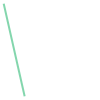

In [366]:
## TEST to create linestrings with shapely

from shapely.geometry import LineString

df = []

r = [33470800, 315120548, 315120548]
for element in r:
    x = Data["Node"][str(element)]["lonlat"]
    x = tuple(x)
    df.append(x)

print(df)

LineString(df)

In [367]:
# Convert multiple coordinate tuples to lines
# with shapely https://shapely.readthedocs.io/en/stable/manual.html


lonlat_column = []
lonlat = []
lonlats = []

for ref in df_way["refs"]:  # goes through each row in df_way['refs']
    lonlats = []
    for (
        r
    ) in (
        ref
    ):  # picks each element in ref & replaces ID by coordinate tuple (A multiline consist of several points)
        lonlat = Data["Node"][str(r)][
            "lonlat"
        ]  # "r" is the ID in Data["Node"], ["lonlat"] a list of [x1,y1] (coordinates)
        lonlat = tuple(lonlat)
        lonlats.append(lonlat)  # a list with tuples
    lonlat_column.append(lonlats)  # adding a new list of tuples every row
df_way.drop("refs", axis=1, inplace=True)
df_way.insert(1, "lonlat", lonlat_column)
df_way["geometry"] = df_way["lonlat"].apply(lambda x: LineString(x))

df_way.head()

id  \
0  102977104   
2  219020310   
3  448830775   
4  448963663   
5  448685912   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [368]:
gdf = gpd.GeoDataFrame(df_way, geometry="geometry", crs="EPSG:4326")
gdf.drop(columns=["lonlat"], inplace=True)
# display(gdf)

##voltage filter
gdf.rename(columns={"tags.voltage": "voltage_V"}, inplace=True)
## some transmission lines carry multiple voltages, having voltage_V = 10000;20000  (two lines)
# The following code keeps only the first information before the semicolon..
# Needs to be corrected in future, creating two lines with the same bus ID.
gdf["voltage_V"] = gdf["voltage_V"].str.split(";").str[0]
gdf["voltage_V"] = gdf["voltage_V"].astype(int)
gdf = gdf[gdf.voltage_V > 10000]
gdf

,id,tags.power,tags.cables,voltage_V,tags.source,geometry
0,102977104,line,3,220000,NaN,"LINESTRING (32.85307 24.02714, 32.85416 24.02726, 32.85479 24.02716)"
2,219020310,line,6,220000,bing,"LINESTRING (30.75225 31.27806, 30.75183 31.27802, 30.75121 31.27883, 30.74953 31.28033, 30.74733 31.27910, 30.74820 31.27705, 30.74892 31.27532, 30.74999 31.27279, 30.75251 31.27167, 30.75582 31.27020, 30.75951 31.26854, 30.76044 31.26544, 30.76132 31.26244, 30.76240 31.25907, 30.76333 31.25614, 30.76425 31.25318, 30.76536 31.24971, 30.76339 31.24709, 30.76151 31.24460, 30.76369 31.24196, 30.76737 31.23922, 30.76650 31.23618, 30.76464 31.23485, 30.76219 31.23308, 30.75925 31.23095, 30.75873 31.22904, 30.75790 31.22586, 30.75711 31.22287, 30.75895 31.22149, 30.76162 31.21939, 30.76184 31.21606, 30.76205 31.21290, 30.76228 31.20935, 30.76436 31.20743, 30.76694 31.20492, 30.76916 31.20276, 30.77129 31.20073, 30.77387 31.19826, 30.77369 31.19489, 30.77346 31.19144, 30.77323 31.18797, 30.76937 31.18690, 30.76766 31.18455, 30.76571 31.18187, 30.76371 31.17913, 30.76174 31.17640, 30.75978 31.17371, 30.75819 31.17154, 30.75629 31.16894, 30.75446 31.16642, 30.75131 31.16586, 30.74826 31.16532, 30.74505 31.16476, 30.74137 31.16412, 30.73783 31.16351, 30.73493 31.16300, 30.73131 31.16236, 30.72807 31.16179, 30.72569 31.16137, 30.72293 31.16088, 30.72012 31.15991, 30.71697 31.15881, 30.71401 31.15779, 30.71096 31.15675, 30.70810 31.15575, 30.70469 31.15458, 30.70195 31.15363, 30.69863 31.15249, 30.69583 31.15151, 30.69241 31.15033, 30.68922 31.14923, 30.68569 31.14799, 30.68216 31.14679, 30.67932 31.14581, 30.67554 31.14682, 30.67206 31.14774, 30.66852 31.14867, 30.66499 31.14962, 30.66128 31.15060, 30.65774 31.15154, 30.65433 31.15244, 30.65092 31.15334, 30.64660 31.15449, 30.64356 31.15529, 30.64115 31.15593, 30.63997 31.15624, 30.63667 31.15712, 30.63313 31.15808, 30.63082 31.16056, 30.62845 31.16310, 30.62645 31.16527, 30.62425 31.16765, 30.62301 31.16897, 30.62210 31.16997, 30.61984 31.17242, 30.61749 31.17496, 30.61516 31.17749, 30.61291 31.17992, 30.61084 31.17990, 30.60840 31.17990, 30.60563 31.17986, 30.60281 31.17802, 30.59829 31.17506, 30.59561 31.17329, 30.59402 31.17215, 30.59181 31.17060, 30.58922 31.16878, 30.58658 31.16691, 30.58389 31.16502, 30.58021 31.16434, 30.57703 31.16376, 30.57334 31.16309, 30.56998 31.16248, 30.56627 31.16180, 30.56239 31.16109, 30.55912 31.16050, 30.55532 31.15980, 30.55189 31.15918, 30.54817 31.15851, 30.54504 31.15794, 30.54312 31.15865, 30.54099 31.15944, 30.53822 31.16047, 30.53773 31.16284, 30.53718 31.16542, 30.53668 31.16783, 30.53609 31.17069, 30.53542 31.17381, 30.53536 31.17409, 30.53621 31.17657, 30.53390 31.17838, 30.53157 31.18016, 30.53170 31.18097)"
3,448830775,line,3,132000,NaN,"LINESTRING (32.91656 24.08400, 32.91671 24.08399, 32.91696 24.08397)"
4,448963663,line,3,220000,NaN,"LINESTRING (33.81842 27.12173, 33.81807 27.12172, 33.81741 27.12159)"
5,448685912,line,3,66000,NaN,"LINESTRING (31.35247 22.66779, 31.35260 22.66760, 31.35284 22.66719)"
...,...,...,...,...,...,...
1884,113013939,line,6,66000,NaN,"LINESTRING (32.91122 24.11607, 32.91275 24.11580, 32.91623 24.11521, 32.91997 24.11457, 32.92327 24.11405, 32.92528 24.11566, 32.92684 24.11693, 32.92896 24.11868, 32.92976 24.12032, 32.93097 24.12288, 32.93228 24.12563, 32.93345 24.12805, 32.93435 24.12994, 32.93575 24.13289, 32.93675 24.13493, 32.93767 24.13687, 32.93623 24.13823, 32.93385 24.14048, 32.93231 24.14195, 32.93024 24.14389, 32.92804 24.14599, 32.92585 24.14806, 32.92267 24.14871, 32.91949 24.14938, 32.91633 24.15004, 32.91316 24.15072, 32.91050 24.15128, 32.90742 24.15193, 32.90464 24.15249, 32.90165 24.15313, 32.89845 24.15379, 32.89588 24.15434, 32.89513 24.15720, 32.89444 24.15991, 32.89399 24.16164, 32.89317 24.16487, 32.89236 24.16803, 32.89170 24.17061, 32.89086 24.17381, 32.89008 24.17688, 32.89082 24.17970, 32.89153 24.18245, 32.89233 24.18547, 32.89314 24.18856, 32.89373 24.19078, 32.89453 24.19382, 32.89517 24.19634, 3

In [369]:
GeoJSON_outputfile = os.path.join(
    os.getcwd(), "data", "osm", country_name + "_substations.geojson"
)
gdf.to_file(GeoJSON_outputfile, driver="GeoJSON")

In [370]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
saudi = world.query('name == "Saudi Arabia"')
yemen = world.query('name == "Yemen"')
iraq = world.query('name == "Iraq"')
oman = world.query('name == "Oman"')
uae = world.query('name == "United Arab Emirates"')
jordan = world.query('name == "Jordan"')
palestine = world.query('name == "Palestine"')
israel = world.query('name == "Israel"')
qatar = world.query('name == "Qatar"')
kuwait = world.query('name == "Kuwait"')
mena = (
    saudi.append(yemen)
    .append(iraq)
    .append(oman)
    .append(uae)
    .append(jordan)
    .append(palestine)
    .append(israel)
    .append(qatar)
    .append(kuwait)
)
africa = world.query('continent == "Africa"').append(mena)

In [371]:
url = "https://development-data-hub-s3-public.s3.amazonaws.com/ddhfiles/144823/africagrid20170906final.geojson"
africa_network = gpd.read_file(url)
africa_substations = gpd.read_file(GeoJSON_outputfile)

<AxesSubplot:>

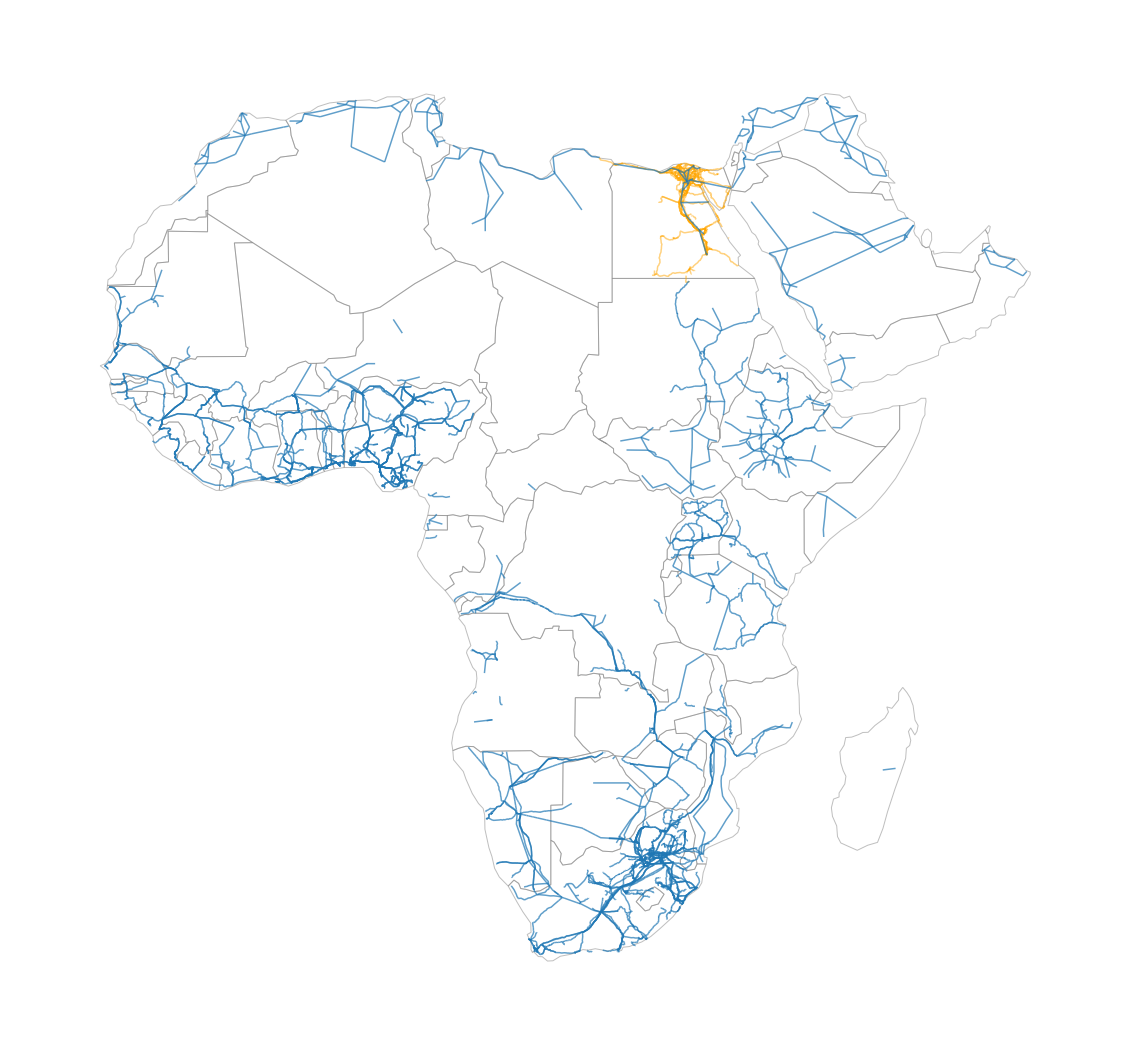

In [372]:
# ax = africa_network[africa_network.voltage_kV > 110].plot(figsize=(20, 20),alpha = 0.7)
ax = gdf.plot(figsize=(20, 20), alpha=0.5, color="orange")  # OSM
geoplot.polyplot(africa, edgecolor="grey", ax=ax, alpha=0.5)
# africa_substations.plot(figsize=(20, 20),markersize=25, color='orange',alpha = 0.5, ax=ax)  #OSM... not in this script available
africa_network[africa_network.voltage_kV > 110].plot(
    figsize=(20, 20), alpha=0.7, ax=ax
)  # Worldbankdata
# plt.savefig('africa_transmission_and substations_110.png')